# Compare NorESM2-LM data with profiles from GLODAPv2.2020

1. Load GLODAPv2.2020 data
2. Import o2 dataset as a xarray.Dataset object
3. Find point coordinates corresponding to GLODAP casts, and nearest corresponding grid point
3. Extract subset of o2 dataset for grid point
4. Plot o2 values: time vs. depth with o2 color scale

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import xarray as xr
import pandas as pd
import numpy as np

In [3]:
from geopy import distance

In [4]:
from os.path import expanduser
home_dir = expanduser("~")

# 1. Import GLODAP data

In [5]:
glodap_file = home_dir + '/data/data/obsdata/GLODAPv2.2020/GLODAPv2.2020_oxygen.csv'
df = pd.read_csv(glodap_file, na_values=-9999)
df

,year,month,day,hour,minute,latitude,longitude,depth,oxygen
0,1984,7,21,13,7,80.7330,12.8530,3.0,400.4
1,1984,7,21,13,7,80.7330,12.8530,37.0,347.7
2,1984,7,21,13,7,80.7330,12.8530,77.0,315.0
3,1984,7,21,13,7,80.7330,12.8530,116.0,317.6
4,1984,7,21,13,7,80.7330,12.8530,156.0,314.1
...,...,...,...,...,...,...,...,...,...
1007801,2018,4,5,16,30,-23.8837,11.1344,6.0,231.2
1007802,2018,4,5,16,30,-23.8837,11.1344,6.0,232.0
1007803,2018,4,5,16,30,-23.8837,11.1344,6.0,231.6
1007804,2018,4,5,16,30,-23.8837,11.1344,6.0,231.1


In [6]:
## Drop data after 2014, for comparison with NorESM2-LM historical data
df = df.drop( df[df['year'] > 2014].index)

In [7]:
## Replace columns "year", "month", "day", "hour" and "minute" with a single "datetime" column
df.insert(loc=0, column='datetime', value=pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']]))
df.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1, inplace=True)

In [8]:
## re-order columns, set 'depth' as column 1
## get a list of columns
cols = list(df)
cols.insert(1, cols.pop(cols.index('depth')))
## use cols order
df = df.loc[:, cols]

In [9]:
## Sort by date and depth
df.sort_values(['datetime', 'depth'], ascending=[True, True], inplace=True)
df = df.reset_index(drop=True)
df

,datetime,depth,latitude,longitude,oxygen
0,1972-07-24 00:00:00,48.0,44.950,-42.0020,265.32
1,1972-07-24 00:00:00,89.0,44.950,-42.0020,234.63
2,1972-07-24 00:00:00,188.0,44.950,-42.0020,216.81
3,1972-07-24 00:00:00,286.0,44.950,-42.0020,203.94
4,1972-07-24 00:00:00,380.0,44.950,-42.0020,190.08
...,...,...,...,...,...
912887,2014-12-22 23:34:00,2800.0,-69.011,-0.0183,230.10
912888,2014-12-22 23:40:00,2500.0,-69.011,-0.0183,227.60
912889,2014-12-22 23:47:00,2200.0,-69.011,-0.0183,223.10
912890,2014-12-22 23:51:00,2000.0,-69.011,-0.0183,221.70


In [10]:
# Convert umol/kg to mol/m3
df['oxygen'] = df['oxygen']*1.028e-3

In [11]:
df_cast = df.drop_duplicates(subset=['datetime', 'latitude', 'longitude'], keep='first')
df_cast

,datetime,depth,latitude,longitude,oxygen
0,1972-07-24 00:00:00,48.0,44.950,-42.0020,0.271953
47,1972-07-25 00:00:00,7.0,48.000,-42.5080,0.286160
103,1972-07-27 00:00:00,18.0,51.025,-43.0170,0.278041
174,1972-07-30 00:00:00,1.0,54.092,-42.9620,0.308484
221,1972-07-31 00:00:00,7.0,56.943,-42.5580,0.319646
...,...,...,...,...,...
912887,2014-12-22 23:34:00,2800.0,-69.011,-0.0183,0.235853
912888,2014-12-22 23:40:00,2500.0,-69.011,-0.0183,0.233290
912889,2014-12-22 23:47:00,2200.0,-69.011,-0.0183,0.228678
912890,2014-12-22 23:51:00,2000.0,-69.011,-0.0183,0.227243


In [12]:
# Round latutude and longitude to nearest whole number value
df = df.round({'latitude': 0, 'longitude': 0})
df_cast = df_cast.round({'latitude': 0, 'longitude': 0})

In [13]:
#df_cast = df.astype({"latitude": np.int32, "longitude": np.int32})
#lat_list = list(range(-90, 91))
#lon_list = list(range(-180, 181))
#cast_count = np.zeros((len(lat_list), len(lon_list)))
#for index, row in df_cast.iterrows():
#    cast_count[row['latitude'], row['longitude']] = cast_count[row['latitude'], row['longitude']] + 1

# 2. Import data as a xarray.Dataset object

In [14]:
## Monthly historical NorESM2-LM 'o2' or 'co3' files
input_files = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/historical/Omon/o2/NorESM2-LM/r1i1p1f1/o2_Omon_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
#input_files = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/historical/Omon/co3/NorESM2-LM/r1i1p1f1/co3_Omon_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
#input_files = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/historical/Omon/talk/NorESM2-LM/r1i1p1f1/talk_Omon_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
dset = xr.open_mfdataset(input_files, combine='by_coords')
title_label = 'hist'

## Yearly "historical + SSP###" NorESM-LM files 
#input_files_hist = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/historical/Oyr/o2/NorESM2-LM/r1i1p1f1/o2_Oyr_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
#input_files_hist = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/historical/Oyr/ph/NorESM2-LM/r1i1p1f1/ph_Oyr_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
#dset_hist = xr.open_mfdataset(input_files_hist, combine='by_coords')

#input_files_ssp126 = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/ssp126/Oyr/o2/NorESM2-LM/r1i1p1f1/o2_Oyr_NorESM2-LM_ssp126_r1i1p1f1_gr_*.nc'
#input_files_ssp126 = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/ssp126/Oyr/ph/NorESM2-LM/r1i1p1f1/ph_Oyr_NorESM2-LM_ssp126_r1i1p1f1_gr_*.nc'
#dset_ssp126 = xr.open_mfdataset(input_files_ssp126, combine='by_coords')
#dset = xr.combine_by_coords([ dset_hist , dset_ssp126])
#title_label = 'hist+ssp126'

#input_files_ssp585 = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/ssp585/Oyr/o2/NorESM2-LM/r1i1p1f1/o2_Oyr_NorESM2-LM_ssp585_r1i1p1f1_gr_*.nc'
#input_files_ssp585 = home_dir + '/data/NTK-data/modeldata/ETHZ_CMIP6/ssp585/Oyr/ph/NorESM2-LM/r1i1p1f1/ph_Oyr_NorESM2-LM_ssp585_r1i1p1f1_gr_*.nc'
#dset_ssp585 = xr.open_mfdataset(input_files_ssp585, combine='by_coords')
#dset = xr.combine_by_coords([ dset_hist , dset_ssp585])
#title_label = 'hist+ssp585'

#dset.attrs = dset_hist.attrs

### Print out info about the dataset

In [15]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 385, lev: 70, time: 1980, vertices: 4)
Coordinates:
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * lev                 (lev) float64 0.0 5.0 10.0 ... 6.25e+03 6.5e+03 6.75e+03
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 dask.array<chunksize=(120, 70, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float64 dask.array<chunksize=(120, 385, 360, 4), me

### Attributes of main variable

In [16]:
eval('dset.' + dset.attrs['variable_id'] + '.attrs')

{'standard_name': 'mole_concentration_of_dissolved_molecular_oxygen_in_sea_water',
 'long_name': 'Dissolved Oxygen Concentration',
 'comment': "'Mole concentration' means number of moles per unit volume, also called 'molarity', and is used in the construction mole_concentration_of_X_in_Y, where X is a material constituent of Y.  A chemical or biological species denoted by X may be described by a single term such as 'nitrogen' or a phrase such as 'nox_expressed_as_nitrogen'.",
 'units': 'mol m-3',
 'original_name': 'o2lvl',
 'cell_methods': 'area: mean where sea time: mean',
 'cell_measures': 'area: areacello volume: volcello',
 'history': "2019-08-15T21:30:58Z altered by CMOR: Converted type from 'd' to 'f'."}

# 3. Define point coordinate and find nearest grid point

The test point at 23.0 degrees South and 12 degrees East is in the Benguela current, close to strong upwelling cells of the Benguela upwelling system. Calculate distances only for grid coordinates inside [lat_bbox,lon_bbox] region around ref_point.

The reference point is compared with (lat,lon) grid coordinates within the bounding box, using the distance function from geopy to identify the nearest one. The distance matrix is initialized with the same size as the (lat,lon) coordinate matrices, and a value expected to be larger than the minimum distance we want to find.

In [17]:
#ref_point = (-23.0, 12.0)
ref_point = (39.0, 137.0)
#ref_point = (65.0, 0.0)
[lat_bbox, lon_bbox] = [2.0, 2.0]

Drop casts that do not correspond to ref_point.

In [18]:
df_point = df[ (df['latitude'] == ref_point[0]) & (df['longitude'] == ref_point[1]) ]
df_point

,datetime,depth,latitude,longitude,oxygen
711230,2008-10-27 07:33:00,2601.0,39.0,137.0,0.209613
711231,2008-10-27 07:35:00,2500.0,39.0,137.0,0.209408
711232,2008-10-27 07:40:00,2250.0,39.0,137.0,0.209510
711233,2008-10-27 07:46:00,2000.0,39.0,137.0,0.209613
711234,2008-10-27 07:54:00,1500.0,39.0,137.0,0.211048
...,...,...,...,...,...
911610,2014-10-11 17:24:00,1600.0,39.0,137.0,0.206128
911611,2014-10-11 17:24:00,1799.0,39.0,137.0,0.205820
911612,2014-10-11 17:24:00,1999.0,39.0,137.0,0.205717
911613,2014-10-11 17:24:00,2250.0,39.0,137.0,0.205410


In [19]:
df_cast_point = df_cast[ (df_cast['latitude'] == ref_point[0]) & (df_cast['longitude'] == ref_point[1]) ]
df_cast_point

,datetime,depth,latitude,longitude,oxygen
711230,2008-10-27 07:33:00,2601.0,39.0,137.0,0.209613
711231,2008-10-27 07:35:00,2500.0,39.0,137.0,0.209408
711232,2008-10-27 07:40:00,2250.0,39.0,137.0,0.209510
711233,2008-10-27 07:46:00,2000.0,39.0,137.0,0.209613
711234,2008-10-27 07:54:00,1500.0,39.0,137.0,0.211048
...,...,...,...,...,...
847251,2012-11-03 18:19:00,11.0,39.0,137.0,0.237421
883489,2013-11-06 22:08:00,0.0,39.0,137.0,0.244668
911107,2014-09-26 20:50:00,0.0,39.0,137.0,0.224680
911133,2014-09-27 05:33:00,0.0,39.0,137.0,0.223142


Extract latitude and longitude grid coordinates as pandas dataframes, for comparison with reference point.

In [20]:
lat = dset.latitude.to_pandas()
lon = dset.longitude.to_pandas()
dist = np.ones((dset.j.size, dset.i.size)) * 1.e6

In [21]:
for j in np.arange(dset.j.size):
    for i in np.arange(dset.i.size):
        if abs(lat.iloc[j,i] - ref_point[0]) < lat_bbox and \
        abs(lon.iloc[j,i] - ref_point[1]) < lon_bbox :
            grid_point = (lat.iloc[j,i], lon.iloc[j,i])
            dist[j,i] = distance.distance(ref_point, grid_point).km

The (j,i) indices corresponding to the minimum distance between a grid point and the reference point must be shifted by 1 to get the (j,i) table values, because python arrays start at [0,0] whereas the table values start at [1,1].

In [22]:
(j_index, i_index) = np.where(dist == dist.min())
j_value = j_index[0] + 1
i_value = i_index[0] + 1
print('Nearest grid point is ', dist.min(), ' km from ref_point, with (j,i) indices ', j_index, ', ', i_index, ' and values ', j_value, ',', i_value )

Nearest grid point is  45.59313559606923  km from ref_point, with (j,i) indices  [276] ,  [247]  and values  277 , 248


In [23]:
[lat_grd, lon_grd] = [lat.loc[j_value,i_value], lon.loc[j_value,i_value]]
print('Nearest grid point is located at (', lat_grd, ',', lon_grd, ')')

Nearest grid point is located at ( 38.87281108055573 , 137.49999751717883 )


# 4. Extract subset of o2 dataset

In [24]:
subset = dset.sel(j=j_value, i=i_value, time=slice("1972-01-01", "2015-01-01"))

In [25]:
subset.data_vars

Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(96, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 dask.array<chunksize=(96, 70, 2), meta=np.ndarray>
    vertices_latitude   (time, vertices) float64 dask.array<chunksize=(96, 4), meta=np.ndarray>
    vertices_longitude  (time, vertices) float64 dask.array<chunksize=(96, 4), meta=np.ndarray>
    o2                  (time, lev) float32 dask.array<chunksize=(96, 70), meta=np.ndarray>

Convert the time variable from 'cftime' format used by xarray to 'datetime' format that can be used by matplotlib.

In [26]:
datetimeindex = subset.indexes['time'].to_datetimeindex()
subset['time'] = datetimeindex

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [27]:
data = eval('subset.' + dset.attrs['variable_id'] + '.to_pandas()')

In [28]:
data = data.swapaxes(0,1)

In [29]:
data

time,1972-01-16 12:00:00,1972-02-15 00:00:00,1972-03-16 12:00:00,1972-04-16 00:00:00,1972-05-16 12:00:00,1972-06-16 00:00:00,1972-07-16 12:00:00,1972-08-16 12:00:00,1972-09-16 00:00:00,1972-10-16 12:00:00,...,2014-03-16 12:00:00,2014-04-16 00:00:00,2014-05-16 12:00:00,2014-06-16 00:00:00,2014-07-16 12:00:00,2014-08-16 12:00:00,2014-09-16 00:00:00,2014-10-16 12:00:00,2014-11-16 00:00:00,2014-12-16 12:00:00
lev,,,,,,,,,,,,,,,,,,,,,
0.0,0.278139,0.284665,0.295408,0.293457,0.285647,0.257168,0.227009,0.219564,0.219616,0.234088,...,0.273867,0.284195,0.278904,0.254010,0.229202,0.216345,0.220886,0.228808,0.243811,0.256255
5.0,0.278132,0.284638,0.295426,0.293466,0.288238,0.263782,0.240215,0.224325,0.220371,0.234103,...,0.273789,0.284237,0.280474,0.256489,0.236412,0.218063,0.221204,0.228983,0.243763,0.256238
10.0,0.277697,0.284286,0.295338,0.293379,0.290108,0.277885,0.260520,0.241333,0.226540,0.234095,...,0.273393,0.284083,0.282819,0.262745,0.254003,0.227558,0.221797,0.229148,0.243495,0.255791
15.0,0.277364,0.284033,0.295238,0.293334,0.290852,0.283515,0.269032,0.251753,0.235082,0.234243,...,0.273161,0.283936,0.285296,0.269311,0.262045,0.236692,0.226115,0.229956,0.243376,0.255494
20.0,0.277327,0.283938,0.295149,0.293139,0.292639,0.287213,0.276055,0.260317,0.244324,0.235460,...,0.273144,0.283812,0.286190,0.276642,0.267819,0.244097,0.233719,0.232504,0.243319,0.255399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5. Plot dataset

In [30]:
y = -data.index.values
x = data.columns.values
X,Y = np.meshgrid(x,y)

In [31]:
cbar_text = dset.attrs['variable_id']
cbar_units = eval('dset.' + dset.attrs['variable_id'] + '.attrs[\'units\']')
if cbar_units != '1':
    cbar_text = cbar_text + ' [' + cbar_units + ']'
title_text = eval('dset.' + dset.attrs['variable_id'] + '.attrs[\'long_name\']') + ' : {0:7.2f} N, {1:7.2f} E : {2!s}'.format(lat_grd,lon_grd,title_label)

Text(0.5,1,'Dissolved Oxygen Concentration :   38.87 N,  137.50 E : hist')

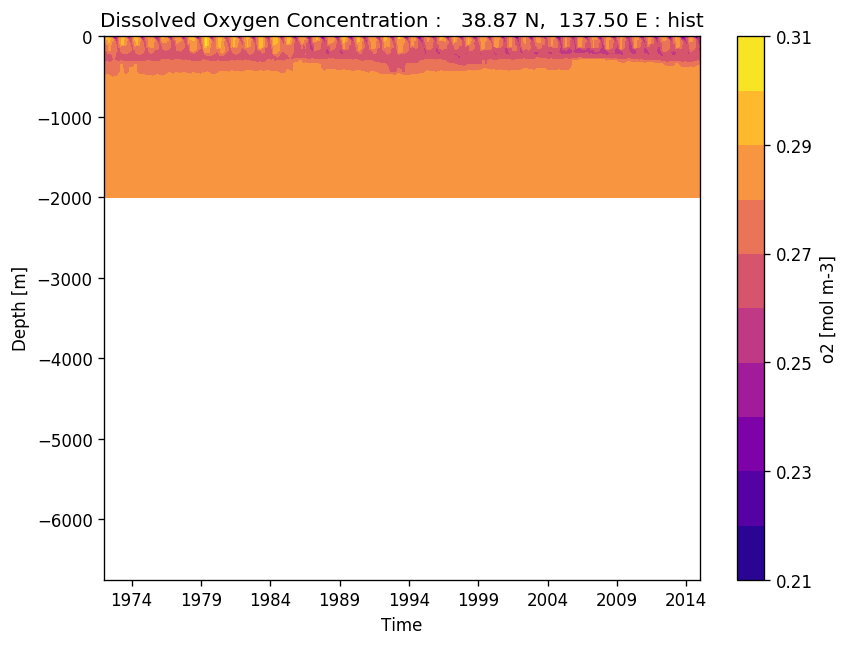

In [32]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.contourf(X, Y, data, 10, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label(cbar_text)
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title(title_text)

Text(0.5,1,'Dissolved Oxygen Concentration :   38.87 N,  137.50 E : hist')

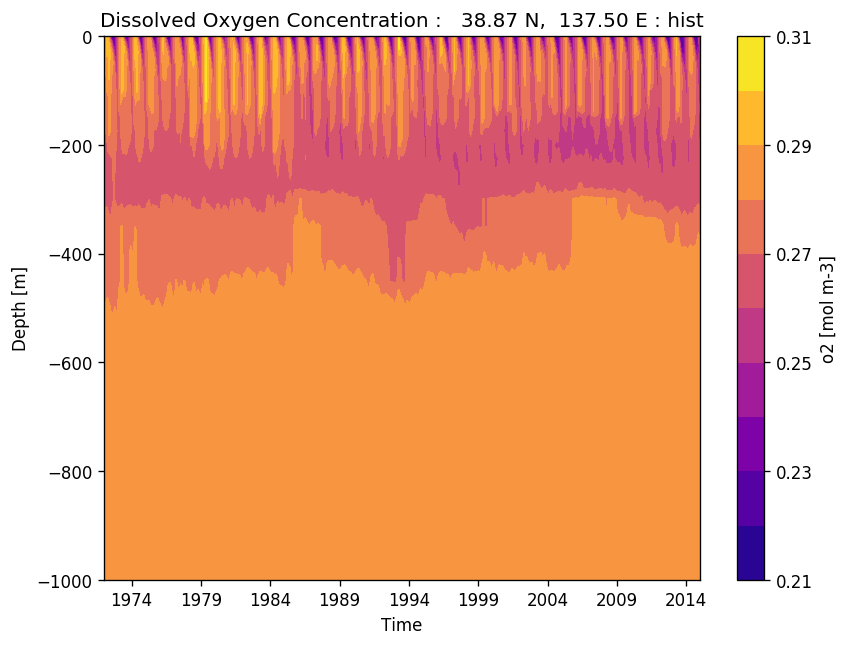

In [33]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.contourf(X, Y, data, 10, cmap='plasma')
plt.ylim(-1000.0 , 0.0)
cbar = plt.colorbar()
cbar.set_label(cbar_text)
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title(title_text)

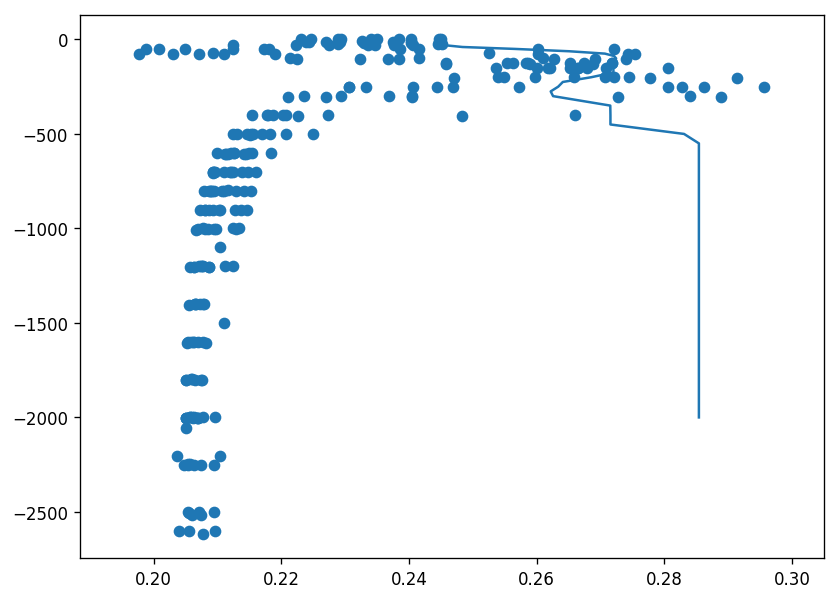

In [34]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.scatter(df_point['oxygen'], -df_point['depth'])
plt.plot(data['1993-11-16 00:00:00'], y)